In [1]:
from src.core import *

from typing import Optional
from dataclasses import dataclass

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.ops import box_iou
from torchvision.transforms.functional import resized_crop

from selectivesearch import selective_search

**Task:**
Given region proposals for an image, annotate each Region of Interest (ROI) with
* Class that it belongs to
* Offset from the ground truth bounding box
* IOU of the ROI with the ground truth bounding box

In [2]:
loader = JSONLoader('data')
df, id2label = loader.load_train()
agg_df = df.groupby('image_id').agg(list).reset_index()

In [3]:
img_path, bboxes, ids = agg_df.loc[35]
img = Image.open(img_path)

img_tensor = transforms.ToTensor()(img)
bboxes, ids = torch.tensor(bboxes), torch.tensor(ids)

In [4]:
@dataclass
class ROIs:
    boxes: torch.FloatTensor
    ids: Optional[torch.IntTensor] = None
    offsets: Optional[torch.FloatTensor] = None
    ious: Optional[torch.FloatTensor] = None
    
    def __post_init__(self):
        self.ids = torch.full((self.boxes.shape[0],), 0, dtype=torch.long)

In [5]:
def extract_rois(img):
    img_area = img.shape[1]*img.shape[2]
    _, regions = selective_search(img.permute((1,2,0)), scale=200, min_size=100)
    rois = torch.tensor([r['rect'] for r in regions])
    sizes = torch.tensor([r['size'] for r in regions])
    mask = (sizes>0.05*img_area) & (sizes<img_area)
    return ROIs(rois[mask, :])

In [6]:
rois = extract_rois(img_tensor)
print(rois.boxes.shape, bboxes.shape)

/home/awesomeville/miniforge3/lib/python3.12/site-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


torch.Size([40, 4]) torch.Size([12, 4])


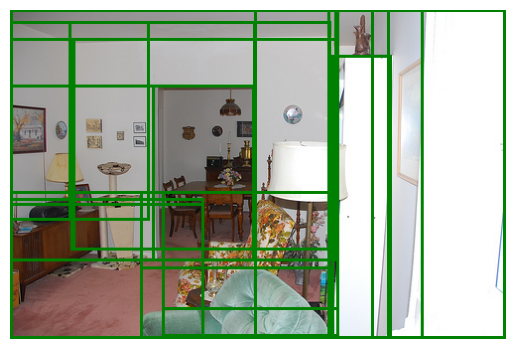

In [7]:
show_bbs(img, rois.boxes)

In [8]:
def annotate_rois(rois, bboxes, ids, cat_thresh=0.3):
    rois.boxes = torch.cat([rois.boxes[:,:2], rois.boxes[:,:2]+rois.boxes[:,2:]], dim=1)
    bboxes = torch.cat([bboxes[:,:2], bboxes[:,:2]+bboxes[:,2:]], dim=1)
    ious = box_iou(rois.boxes, bboxes)
    max_ious, max_idxs = ious.max(dim=1)
    valid_mask = max_ious>cat_thresh
    rois.ids[valid_mask] = ids[max_idxs[valid_mask]]
    offsets = bboxes[max_idxs]-rois.boxes
    widths, heights = rois.boxes[:, 2], rois.boxes[:, 3]
    rois.offsets = torch.stack([
        offsets[:, 0] / widths,  # dx / width
        offsets[:, 1] / heights,  # dy / height
        offsets[:, 2] / widths,  # dw / width
        offsets[:, 3] / heights  # dh / height
    ], dim=1)
    rois.ious = max_ious
    return rois

In [9]:
rois = annotate_rois(rois, bboxes, ids)

In [13]:
class ObjectDataset(Dataset):
    def __init__(self, df, extract_rois, cat_thresh=0.3, crop_size=(112,112)):
        self.df = df.groupby('image_id').agg(list).reset_index()
        self.extract_rois = extract_rois
        self.crop_size = crop_size
        self.cat_thresh = cat_thresh
        self.img_tfms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path, bboxes, ids = agg_df.loc[idx]
        img = Image.open(img_path)
        img = self.img_tfms(img)
        bboxes = torch.tensor(bboxes, dtype=torch.float32)
        ids = torch.tensor(ids, dtype=torch.long)

        rois = self.extract_rois(img)
        rois = annotate_rois(rois, bboxes, ids, self.cat_thresh)
        crops = []
        for box in rois.boxes:
            x_min, y_min, w, h = box.int().tolist()
            cropped_img = resized_crop(img, top=y_min, left=x_min, height=h, width=w, size=self.crop_size)
            crops.append(cropped_img)
        crops = torch.stack(crops)

        return {'crops':crops, 'rois':rois}

    def collate_fn(self, batch):
        all_crops = torch.cat([item['crops'] for item in batch], dim=0)
        all_ids = torch.cat([item['rois'].ids for item in batch], dim=0)
        all_offsets = torch.cat([item['rois'].offsets for item in batch], dim=0)
        
        return {'crops':all_crops, 'ids':all_ids, 'offsets':all_offsets}

In [17]:
ds = ObjectDataset(df=df, extract_rois=extract_rois)
dl = DataLoader(ds, batch_size=4, shuffle=True, collate_fn=ds.collate_fn)

In [18]:
batch = next(iter(dl))

/home/awesomeville/miniforge3/lib/python3.12/site-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


In [16]:
batch['crops'].shape, batch['ids'].shape, batch['offsets'].shape

(torch.Size([787, 3, 112, 112]), torch.Size([787]), torch.Size([787, 4]))